Ce notebook contient toutes les étapes qui nous permettent de traiter les données et d'entrainer notre IA.

Importations

In [14]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import gc

Definition de quelques fonctions utiles :

In [4]:
def load_images_from_folder(folder_path, target_size=None):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path)
            if target_size:
                image = image.resize(target_size)  # Redimensionner l'image si nécessaire
            image_array = np.array(image)  # Convertir l'image en tableau NumPy
            images.append(image_array)
            filenames.append(filename)
    return np.array(images), filenames

def normalize(images):
    s=images.shape
    images = images.astype("float32")/255
    images = images.reshape(s[0],s[1]*s[2]*s[3])
    return images

def normalize_conv(images):
    images = images.astype("float32")/255
    return images

def denormalize(img):
    img = img.reshape(400,400,3)
    return img

def plotimage(img):
    img = denormalize(img)
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()



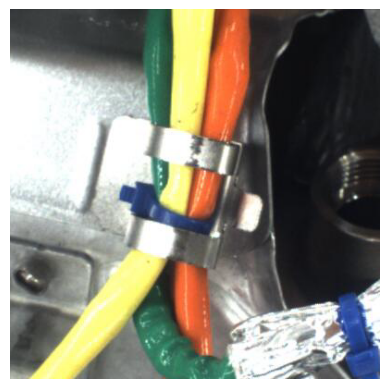

In [5]:
folder_path = '/home/jgayraud/Documents/MIC3/BE/engine_wiring/train/good'
target_size = (400, 400)  
images, filenames = load_images_from_folder(folder_path, target_size)

images_conv = normalize_conv(images)
images = normalize(images)
plotimage(images[3,:])


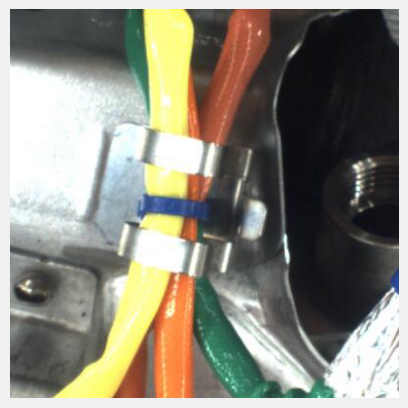

In [6]:

images_conv.shape


(285, 400, 400, 3)

Le code suivant est la classe permettant de créer cette IA avec  plusieurs fonctions

Definition du modèle :

In [7]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(400*400*3, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 20)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,400*400*3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
class AE_CNN(torch.nn.Module):
    def __init__(self):
        super(AE_CNN, self).__init__()
       
        # --- ENCODEUR CNN ---
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 400x400 → 200x200
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 200x200 → 100x100
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 100x100 → 50x50
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 50x50 → 25x25
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 25 * 25, 20)  # Vecteur latent de taille 20
        )
       
        # --- DÉCODEUR CNN ---
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 256 * 25 * 25),  # Reconversion du vecteur latent
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (256, 25, 25)),  # Reformater en "image" 2D
           
            torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 25x25 → 50x50
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 50x50 → 100x100
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 100x100 → 200x200
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 200x200 → 400x400
            torch.nn.Sigmoid()  # Normalisation entre 0 et 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.device("cpu") 
print(device)

cuda


Definition du loader ( la database qui va servir à s'entrainer en prenant en compte le bash (nombre d'itérations avant update)) et de certains hyperparamètres

# Définition de certains hyperparamètres

Dans la cellule de code qui suit, nous avons fixé les paramètres suivants:
- La **taille du bash** (32). Le modèle est mis à jour toutes les 32 images.
- **Adam optimizer** : c'est un algorithme d'optimisation qui modifie les poids du modèle dans la direction qui minimise l'erreur de reconstruction. De plus, il prend en compte le nombre de fois que les poids sont modifiés et l'importance du changement (plus un poids est sujet au changement moins on va le modifier pour éviter des fluctuations élevées de la qualité du modèle en fonction de l'image d'entrée).
- La **Learning Rate** (lr = 1e-3) représente la vitesse d'apprentissage. Si c'est trop grand les poids du modèle risquent de trop osciller et si c'est petit l'apprentissage est long. Nous avons utilisé une valeur standard.
-la **Weight Decay** (1e-5) est un paramètre qui ajoute une pénalité sur la taille des poids du modèle pour éviter qu'ils deviennent trop grands. Cela aide à prévenir l'overfitting et rend l'apprentissage plus stable. Nous avons utilisé une valeur standard

Nous avons choisi une première valeur pour ces hyperparamètres en regardant des tutos et en copiant les valeurs. Puis nous avons réévalué la learning rate (0.1 -> 1e-3) car nous avions choisi une valeur trop élevée qui amenait à un surapprentissage du modèle.

# Adaptation des données au modèle

Nous avons aussi créé des tensors grace à la bibliothèque torch pour pouvoir utiliser nos images dans l'entraînement du modèle

In [ ]:
# les to(device) deplace les objets sur le gpu pour faire le training
torch.cuda.empty_cache()
if 'model' in locals():
    del model
if 'optimizer' in locals():
    del optimizer
if 'images_tensor' in locals():
    del images_tensor
if 'dataset' in locals():
    del dataset
if 'loader' in locals():
    del loader


model = AE_CNN().to(device)
BashSize = 32


loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)


images_tensor = torch.tensor(images, dtype=torch.float32).to(device)

images_tensor_conv = torch.tensor(images_conv, dtype=torch.float32).permute(0,3,1,2).to(device)


#dataset = TensorDataset(images_tensor)

loader = torch.utils.data.DataLoader(dataset = images_tensor_conv,
                                     batch_size = BashSize,
                                     shuffle = True)

Entrainement du modèle :

In [58]:
num_epochs = 100
losses = []
optimizer.zero_grad()
for epoch in range(num_epochs):
    for batch in loader:
        # Séparer les données d'entrée et les cibles (ici, les mêmes images)
        inputs = batch.to(device)
        targets = inputs
        
        # Passer les données dans le modèle

        outputs = model(inputs)
        # Calculer la perte
        loss = loss_function(outputs, targets)
        
        # Rétropropagation et mise à jour des poids

        loss.backward()
        optimizer.step()    
        # Remettre les gradients à zéro
        optimizer.zero_grad()
        

        losses.append(loss.item())
        # supprimer ce qui ne nous sert plus pour libérer la mémoire (probleme de taille)
        del inputs, targets, outputs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Entraînement terminé.")



Epoch [1/100], Loss: 0.6931
Epoch [2/100], Loss: 0.6923
Epoch [3/100], Loss: 0.6887
Epoch [4/100], Loss: 0.6089
Epoch [5/100], Loss: 0.5669
Epoch [6/100], Loss: 0.5435
Epoch [7/100], Loss: 0.5477
Epoch [8/100], Loss: 0.5488
Epoch [9/100], Loss: 0.5467
Epoch [10/100], Loss: 0.5466
Epoch [11/100], Loss: 0.5421
Epoch [12/100], Loss: 0.5419
Epoch [13/100], Loss: 0.5406
Epoch [14/100], Loss: 0.5347
Epoch [15/100], Loss: 0.5383
Epoch [16/100], Loss: 0.5307
Epoch [17/100], Loss: 0.5182
Epoch [18/100], Loss: 0.5217
Epoch [19/100], Loss: 0.5197
Epoch [20/100], Loss: 0.5177
Epoch [21/100], Loss: 0.5090
Epoch [22/100], Loss: 0.5073
Epoch [23/100], Loss: 0.4977
Epoch [24/100], Loss: 0.5058
Epoch [25/100], Loss: 0.5000
Epoch [26/100], Loss: 0.5005
Epoch [27/100], Loss: 0.4926
Epoch [28/100], Loss: 0.4891
Epoch [29/100], Loss: 0.4927
Epoch [30/100], Loss: 0.4922
Epoch [31/100], Loss: 0.4941
Epoch [32/100], Loss: 0.4924
Epoch [33/100], Loss: 0.4876
Epoch [34/100], Loss: 0.4823
Epoch [35/100], Loss: 0

# Evolution de l'erreur de reconstruction

Durant l'entraînement, nous avons enregistré les erreurs de reconstruction pour chaque batch.
Nous avons représenté ci-dessous l'évolution de l'erreur de reconstruction au fil des batchs. Nous remarquons que la plus forte pente est obtenue entre le batch 0 et le batch 100, en effet, l'ereur a diminué de 0.75 à 0.55 avant la fin de la période 13. Cela représente plus de la moitié de la diminution de l'erreur obtenue à la fin de l'entraînement

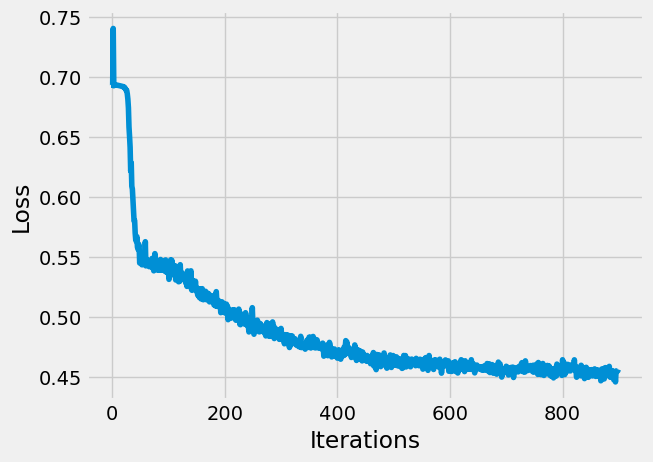

In [59]:
losses_np = [loss for loss in losses]

# Définir le style du graphique
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Tracer les 100 dernières valeurs de perte
plt.plot(losses_np[:])

# Afficher le graphique
plt.show()

# Visualisation

Afin de tester nos modèles nous testons d'afficher l'image originale et son image reconstruite pour vérifier le bon fonctionnement du modèle.

Il y a 2 codes différents pour nos deux types de modèles car le format d'entrée n'est pas le même (vecteur pour l'un et tenseur pour l'autre)

## Code pour afficher l'image originale et l'image reconstruite par le modèle linéaire

In [27]:
# Convertir l'image en tenseur
number = 3

image_tensor = torch.tensor(images[number, :], dtype=torch.float32).view(1, -1)

# Passer l'image à travers le modèle pour obtenir la reconstruction
model.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images[number, :].reshape(400, 400, 3)
reconstructed_image = reconstructed_image.view(400, 400, 3).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 480000]

## Code pour afficher l'image originale et l'image reconstruite par le modèle de convolution

torch.Size([1, 3, 400, 400])


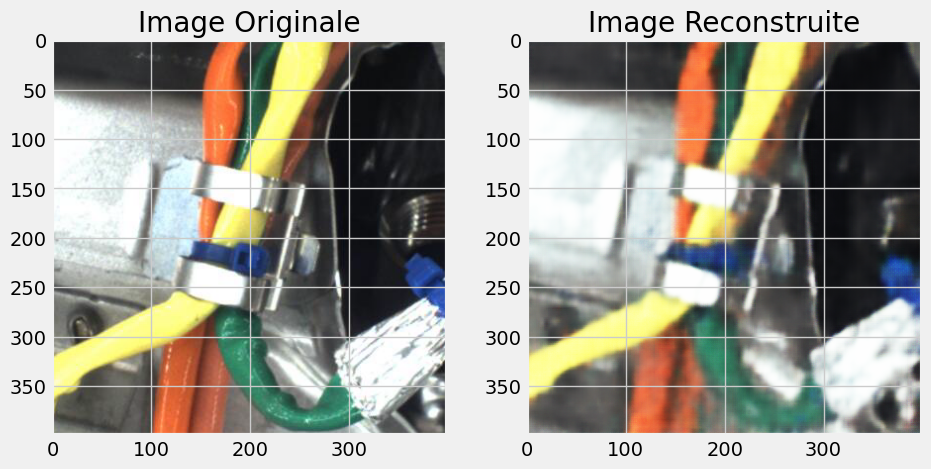

In [78]:
# Convertir l'image en tenseur
number = 20

image_tensor = torch.tensor(images_conv[number, :,:,:], dtype=torch.float32).to(device).permute(2,0,1).reshape(1,3,400,400)
print(image_tensor.shape)
# Passer l'image à travers le modèle pour obtenir la reconstruction
model.to(device).eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images_conv[number, :,:,:]

reconstructed_image = reconstructed_image.cpu().squeeze(0).permute(1,2,0).numpy()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()


Pour l'instant, nous avons une image de sortie similaire peu importe l'image de départ. On suppose que le modèle est mal entrainé (Trop d'époques ou autres), ou une erreur dans lecode

# Enregistrement des poids

In [70]:
torch.save(model.state_dict(),'/home/jgayraud/Documents/MIC3/BE/Detection-d-anomalie/model.pth')

# Chargement du modèle déjà entrainé

In [67]:

loadmodel = AE_CNN().to(device)
loadmodel.load_state_dict(torch.load('/home/jgayraud/Documents/MIC3/BE/Detection-d-anomalie/model.pth'))

<All keys matched successfully>

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])
(400, 400, 3)


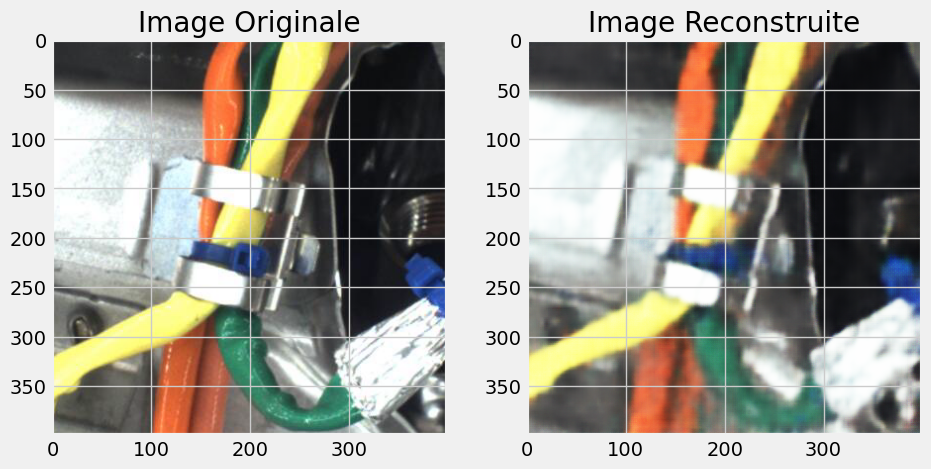

In [73]:
# Convertir l'image en tenseur
number = 20

image_tensor = torch.tensor(images_conv[number, :,:,:], dtype=torch.float32).to(device).permute(2,0,1).reshape(1,3,400,400)
print(image_tensor.shape)
# Passer l'image à travers le modèle pour obtenir la reconstruction
loadmodel.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = loadmodel(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images_conv[number, :,:,:]
print(reconstructed_image.shape)
reconstructed_image = reconstructed_image.cpu().squeeze(0).permute(1,2,0).numpy()

print(reconstructed_image.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()


# Reconstruction d'images de test avec et sans anomalies  

In [83]:
test_number =3
imageTest_tensor = torch.tensor(test_images_conv[test_number, :,:,:], dtype=torch.float32).to(device).permute(2,0,1).reshape(1,3,400,400) 

torch.Size([1, 3, 400, 400])
(400, 400, 3)


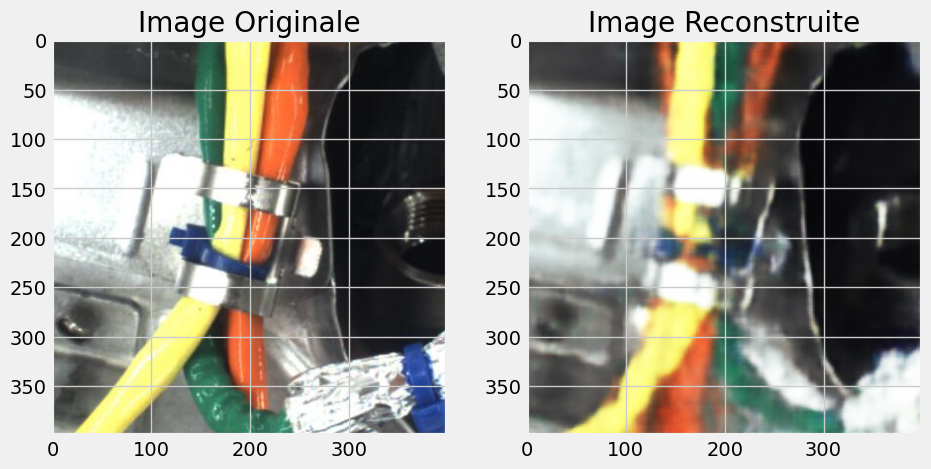

In [84]:
with torch.no_grad():
    reconstructedTest_image = loadmodel(imageTest_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_testimage = images_conv[test_number, :,:,:]
print(reconstructedTest_image.shape)
reconstructedTest_image = reconstructedTest_image.cpu().squeeze(0).permute(1,2,0).numpy()

print(reconstructedTest_image.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_testimage)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructedTest_image)

plt.show()
